# Simulate projectile motion with air resistance

In [1]:
import cmath
import numpy as np
import scipy.integrate
import scipy.optimize
import matplotlib.pyplot as plt

In [3]:
# Measured empirically
PROJECTILE_MASS = 12e-3  # 12g
PROJECTILE_DIAMETER = 28e-3  # 28mm

# Air resistance parameters
COEFF_DRAG_SPHERE = 0.47
RHO_AIR = 1.225  # kg/m^3

In [ ]:
# Acceleration due to drag = velocity**2 * air_resistance(mass, diameter)
def air_resistance(mass, diameter):
    cross_section = np.pi * (diameter / 2) ** 2
    return 0.5 * COEFF_DRAG_SPHERE * RHO_AIR * cross_section / mass


# state = [position, velocity]
def diff_eq_projectile_motion(t, state, D=0):
    velocity = state[1]
    # d/dt state = [velocity, accleration]
    drag_accel = -1 * D * velocity * abs(velocity)
    gravity_accel = -1 * scipy.constants.g * complex(0, 1)
    return [velocity, drag_accel + gravity_accel]


def hit_ground(t, state, *args):
    position = state[0]
    return position.imag


hit_ground.terminal = True
hit_ground.direction = -1


def solve_diff_eq(launch_velocity, launch_angle, air_resistance):
    initial_position = 0
    initial_velocity = cmath.rect(launch_velocity, np.radians(launch_angle))
    t_bounds = [0, 100]
    solution = scipy.integrate.solve_ivp(
        diff_eq_projectile_motion,
        t_bounds,
        [initial_position, initial_velocity],
        dense_output=True,
        events=hit_ground,
        args=(air_resistance,),
    )
    return solution

[array([[128.75057614+1.77635684e-15j,   9.34468782-1.94954730e+01j]])]


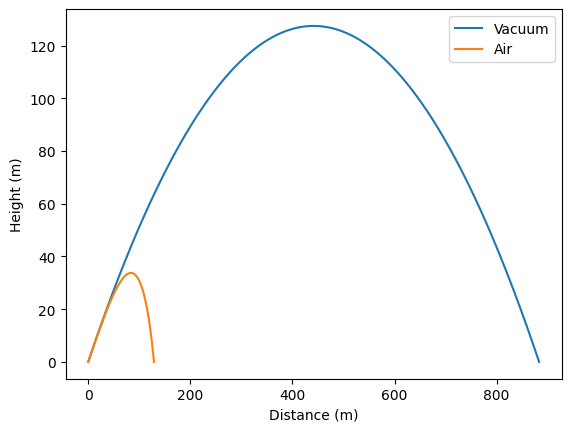

In [5]:
launch_velocity = 100
launch_angle = 30
solution_vacuum = solve_diff_eq(launch_velocity, launch_angle, air_resistance=0)
solution_air = solve_diff_eq(
    launch_velocity,
    launch_angle,
    air_resistance=air_resistance(PROJECTILE_MASS, PROJECTILE_DIAMETER),
)
print(solution_air.y_events)

# plot the trajectories
t_eval = np.linspace(0, solution_vacuum.t_events[0][0], 1000)
points = solution_vacuum.sol(t_eval).T
plt.plot(points[:, 0].real, points[:, 0].imag, label="Vacuum")

t_eval = np.linspace(0, solution_air.t_events[0][0], 1000)
points = solution_air.sol(t_eval).T
plt.plot(points[:, 0].real, points[:, 0].imag, label="Air")

plt.xlabel("Distance (m)")
plt.ylabel("Height (m)")
plt.legend()
plt.show()

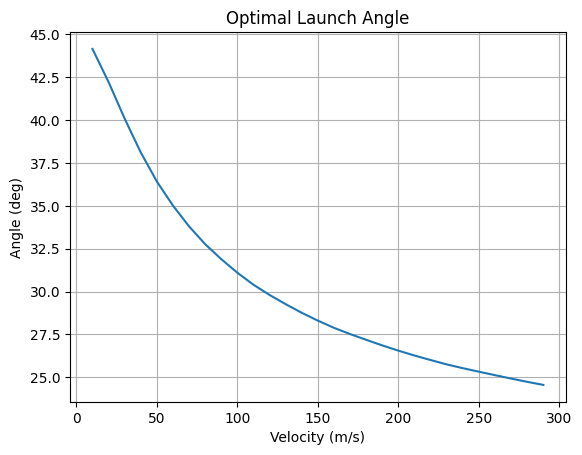

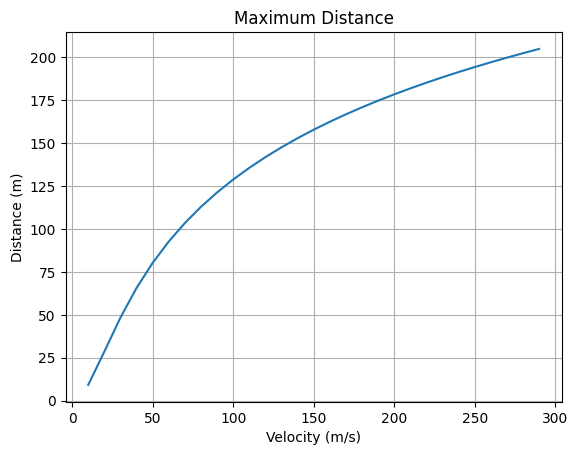

In [6]:
# Find optimal launch angle and maximum distance
def neg_launch_distance(angle, velocity, air_resistance):
    solution = solve_diff_eq(velocity, angle, air_resistance)
    return -solution.y_events[0][0][0].real


launch_velocities = range(10, 300, 10)
optimal_angles = []
max_distances = []

for launch_velocity in launch_velocities:
    optimal = scipy.optimize.minimize_scalar(
        neg_launch_distance,
        bounds=(0, 90),
        args=(launch_velocity, air_resistance(PROJECTILE_MASS, PROJECTILE_DIAMETER)),
    )
    optimal_angles.append(optimal.x)
    max_distances.append(-optimal.fun)

plt.plot(launch_velocities, optimal_angles)
plt.title("Optimal Launch Angle")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Angle (deg)")
plt.grid()
plt.show()

plt.plot(launch_velocities, max_distances)
plt.title("Maximum Distance")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Distance (m)")
plt.grid()
plt.show()